# Transfer Learning with ResNet18

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

### **Mean and Standard Deviation Arrays:**

- mean = np.array([0.5, 0.5, 0.5])
- std = np.array([0.25, 0.25, 0.25]) \
These lines define the mean and standard deviation for each channel (Red, Green, Blue) of the images. These values are used for normalizing the images. Normalization helps in speeding up the training and leads to faster convergence.

### **Data Transformations:**

- The data_transforms dictionary contains two keys: 'train' and 'val', representing the training and validation datasets, respectively.
- Each key maps to a transforms.Compose object, which is a sequence of transformations applied to the images.

### **Transformations for Training Data ('train'):**

- transforms.RandomResizedCrop(224): Randomly crops the image to 224x224 pixels. This adds variability to the dataset and helps the model generalize better.
- transforms.RandomHorizontalFlip(): Randomly flips the image horizontally. This is another technique to increase the diversity of the training data.
- transforms.ToTensor(): Converts the image to a PyTorch tensor.
- transforms.Normalize(mean, std): Normalizes the tensor image with the specified mean and standard deviation.

### **Transformations for Validation Data ('val'):**

- transforms.Resize(256): Resizes the image to 256 pixels on the shorter side while maintaining the aspect ratio.
- transforms.CenterCrop(224): Crops the center of the image to a size of 224x224 pixels.
- transforms.ToTensor(): Converts the image to a PyTorch tensor.
- transforms.Normalize(mean, std): Normalizes the tensor image with the specified mean and standard deviation.

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}



### Loading the data

In [3]:
data_dir = 'data_beexant/archive/hymenoptera_data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


In [4]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

Get a batch of training data

In [5]:
inputs, classes = next(iter(dataloaders['train']))

Make a grid from batch

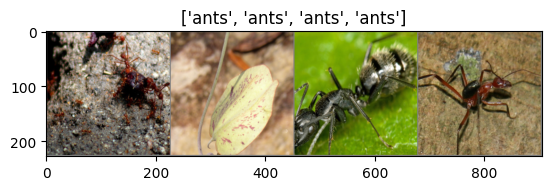

In [6]:
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### **Function Parameters:**

- `model`: The neural network model to be trained.
- `criterion`: The loss function used to evaluate the model's performance.
- `optimizer`: The optimization algorithm used to update the model's weights.
- `scheduler`: A learning rate scheduler that adjusts the learning rate during training.
- `num_epochs`: The number of training iterations over the entire dataset (default is 25).

### **Initialization:**

- The function records the start time.
- It initializes `best_model_wts` with the model's current state (weights). This is used to keep track of the best performing model on the validation data.
- `best_acc` is initialized to 0.0 to track the highest accuracy achieved on the validation set.

### **Training and Validation Loop:**

- The function loops over the number of epochs.
- For each epoch, it iterates through two phases: 'train' and 'val' (validation).
- In the 'train' phase, the model is set to training mode (`model.train()`), enabling features like dropout and batch normalization specific to training.
- In the 'val' phase, the model is set to evaluation mode (`model.eval()`), which disables those training-specific features.

### **Data Iteration:**

- For each phase, the function iterates over the data provided by `dataloaders[phase]`.
- `inputs` and `labels` are loaded onto the device (like a GPU or CPU).
- The model's forward pass is computed, and the loss is calculated using `criterion`.
- If in the 'train' phase, it performs a backward pass and updates the model weights.

### **Statistics:**

- It calculates running loss and the number of correct predictions to compute the accuracy.
- After each epoch, it prints out the loss and accuracy for both training and validation phases.

### **Model Checkpointing:**

- If the model performs better on the validation set than it has in previous epochs (in terms of accuracy), its state is saved as the new best model.

### **Scheduler Step:**

- For the training phase, the learning rate scheduler adjusts the learning rate after each epoch.

### **Final Output:**

- After all epochs, the function prints the total time taken for training and the best accuracy achieved on the validation set.
- The model's weights are updated to the best model weights found during training.

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Finetuning the Resnet
Load a pretrained model and reset final fully connected layer.

https://towardsdatascience.com/resnets-why-do-they-perform-better-than-classic-convnets-conceptual-analysis-6a9c82e06e53


In [8]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

c:\Users\u0161169\AppData\Local\miniconda3\envs\env_pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\u0161169\AppData\Local\miniconda3\envs\env_pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Here the size of each output sample is set to 2.
Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

In [9]:
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [11]:
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs

# Decay LR by a factor of 0.1 every 7 epochs

# Learning rate scheduling should be applied after optimizer’s update

# e.g., you should write your code this way:
# <pre>
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
# </pre>

In [12]:
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6325 Acc: 0.6352
val Loss: 0.5102 Acc: 0.7190

Epoch 1/24
----------
train Loss: 0.5004 Acc: 0.7787
val Loss: 0.3519 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4824 Acc: 0.7705
val Loss: 0.2854 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4230 Acc: 0.8115
val Loss: 0.2492 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3803 Acc: 0.8361
val Loss: 0.2419 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4103 Acc: 0.8115
val Loss: 0.2215 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3256 Acc: 0.8648
val Loss: 0.2088 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3924 Acc: 0.8484
val Loss: 0.2081 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3801 Acc: 0.8279
val Loss: 0.1997 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3540 Acc: 0.8484
val Loss: 0.2027 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3401 Acc: 0.8607
val Loss: 0.2009 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3039 Acc: 0.8730
val Loss: 0.2360 Acc: 0.9085

Ep

#### ResNet as fixed feature extractor #### 

### Here, we need to freeze all the network except the final layer.

### We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()

In [13]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html  Info about Resnet18


### Parameters of newly constructed modules have requires_grad=True by default

In [14]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

### Observe that only parameters of final layer are being optimized as opposed to before.

In [15]:
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

### Decay LR by a factor of 0.1 every 7 epochs

In [16]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5564 Acc: 0.7049
val Loss: 0.3221 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.4944 Acc: 0.7500
val Loss: 0.1920 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3367 Acc: 0.8607
val Loss: 0.1958 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.3458 Acc: 0.8566
val Loss: 0.2098 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.5017 Acc: 0.7951
val Loss: 0.2347 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4807 Acc: 0.8033
val Loss: 0.1845 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4923 Acc: 0.8156
val Loss: 0.2073 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3071 Acc: 0.8566
val Loss: 0.1842 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3818 Acc: 0.8361
val Loss: 0.1989 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3519 Acc: 0.8484
val Loss: 0.2000 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.4136 Acc: 0.8238
val Loss: 0.1924 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4115 Acc: 0.8156
val Loss: 0.1952 Acc: 0.9346

Ep